# ESG Multiclass News Classification with RoBERTa

## Introduction

In this notebook, we train a **RoBERTa-based model** to perform **multiclass classification** on ESG-related news articles.  
Unlike previous binary classification (ESG vs Not ESG), here we aim to classify each article into one of the three ESG pillars:

- **Environmental (E)**
- **Social (S)**
- **Governance (G)**

This multiclass approach allows us to extract more granular ESG information, enabling a richer and more detailed foundation for subsequent ESG scoring and investment algorithms.

Fine-grained ESG classification is essential for building robust ESG analysis frameworks.  
Distinguishing whether an article refers to Environmental, Social, or Governance issues provides valuable insights for:

- **Risk management**
- **Thematic investing**
- **Corporate responsibility analysis**

By developing a specific ESG multiclass classifier, we significantly improve the quality of the ESG scoring system, making it more actionable and informative.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import joblib
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/sample_e_s_g.csv'
df_trainning = pd.read_csv(path)
df_trainning

,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description,text,esg_pred,esg_category
0,NaN,2021-08-03T03:06:08Z,Tesla's India Plans Dealt Blow As Minister Rul...,Elon Musk has complained that Indian rules pro...,NDTV News,NaN,NaN,tesla,NaN,https://www.ndtv.com/india-news/teslas-india-p...,TSLA,India said it has no plans to cut import dutie...,Tesla's India Plans Dealt Blow As Minister Rul...,1,Governance
1,NaN,2022-11-18T17:00:16Z,Black Tech Workers Share Anxious Mood Inside A...,The year has left the tech industry battered a...,Business Insider,NaN,NaN,apple,NaN,https://www.businessinsider.com/black-tech-wor...,AAPL,"At the AfroTech conference, Black tech workers...",Black Tech Workers Share Anxious Mood Inside A...,1,Social
2,NaN,2021-09-21T01:13:12Z,New study says the moon might impact sleep qua...,Most modern wearable devices offer sleep track...,BGR,NaN,NaN,apple,NaN,https://bgr.com/science/new-study-says-the-moo...,AAPL,Most modern wearable devices offer sleep track...,New study says the moon might impact sleep qua...,1,Social
3,NaN,2021-04-12T14:30:43Z,Google and Apple block update to England’s con...,An update to England and Wales contact-tracing...,The Next Web,NaN,NaN,google,NaN,https://thenextweb.com/news/nhs-covid-19-conta...,GOOGL,An update to England and Wales’ contact-tracin...,Google and Apple block update to England’s con...,1,Governance
4,2407.0,2023-12-06 20:25:03+00:00,There's an uptick in Amazon employees quitting...,Some Amazon employees have noticed an increasi...,Business Insider,negative,1.0,amazon,Technology,NaN,AMZN,NaN,There's an uptick in Amazon employees quitting...,1,Social
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,NaN,2020-08-28T01:07:39Z,"Champ pays tribute to BLM with shoes, message","OLYMPIA FIELDS, Ill. -- There was not a lot of...",ESPN,NaN,NaN,nike,NaN,https://www.espn.com/golf/story/_/id/29755957/...,NKE,"Cameron Champ had the word ""equality"" written ...","Champ pays tribute to BLM with shoes, message....",1,Social
7996,NaN,2021-08-31T19:11:44Z,Johnson & Johnson HIV vaccine trial fails mid-...,In yet another setback in the decadeslong scie...,ABC News,NaN,NaN,johnson & johnson,NaN,https://abcnews.go.com/Health/johnson-johnson-...,JNJ,A Johnson & Johnson HIV vaccine candidate fail...,Johnson & Johnson HIV vaccine trial fails mid-...,1,Social
7997,NaN,2022-06-28T16:02:02Z,Microsoft must get better in reporting global ...,Britain-based proxy advisers Pensions &amp; In...,Neowin,NaN,NaN,microsoft,NaN,https://www.neowin.net/news/microsoft-must-get...,MSFT,Microsoft should submit a tax transparency rep...,Microsoft must get better in reporting global ...,1,Governance
7998,NaN,2020-08-17 08:15:00,Oil: Sector Ready To Double - How To Play It,US oil production bounced back but remained ne...,Seeking Alpha,NaN,NaN,conoco,NaN,https://seekingalpha.com/article/4368470-oil-s...,COP,NaN,Oil: Sector Ready To Double - How To Play It. ...,1,Environmental


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
df_balanced = df_trainning.rename(columns={'esg_category': 'label'})

In [ ]:
df_balanced = df_balanced[['text', 'label']].copy()
label_map = {'Environmental': 0, 'Social': 1, 'Governance': 2}
df_balanced['label'] = df_balanced['label'].map(label_map)

In [ ]:
df_balanced['label'].value_counts()

,count
label,
2,3448
1,2872
0,1680


In [ ]:
from sklearn.utils import resample
class_0 = df_balanced[df_balanced['label'] == 0]
class_1 = df_balanced[df_balanced['label'] == 1]
class_2 = df_balanced[df_balanced['label'] == 2]

class_1_downsampled = resample(class_1, replace=False, n_samples=1680, random_state=42)
class_2_downsampled = resample(class_2, replace=False, n_samples=1680, random_state=42)

df_balanced_final = pd.concat([class_0, class_1_downsampled, class_2_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_balanced_final['label'].value_counts()

,count
label,
2,1680
1,1680
0,1680


In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'targets': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [ ]:
df_balanced_final

,text,label
0,"Ottawa open to tweaking online news bill, as G...",2
1,Amazon had keys to USPS mailbox used for union...,1
2,Bangladesh becomes top beneficiary of US COVID...,1
3,Pfizer nixes more study of twice-daily obesity...,1
4,All Australian Apple Stores Reopen. Apple has ...,1
...,...,...
5035,Goldman Sachs was fined $3 million after it mi...,2
5036,Polestar taps Google’s latest in-car tech - TE...,0
5037,US Executives Reveal Why They're Refusing Body...,1
5038,Tesla announces a 5-for-1 stock split. Tesla o...,2


In [ ]:
df_balanced_final.reset_index(drop=True, inplace=True)

In [ ]:
train_df, temp_df = train_test_split(df_balanced_final, test_size=0.3, random_state=42, stratify=df_balanced_final['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Train: 3528 samples
Validation: 756 samples
Test: 756 samples


In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = self.dropout(output.pooler_output)
        return self.out(pooled_output)

model = RoBERTaClass().to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
best_val_loss = float('inf')
patience = 3
counter = 0
best_model_path = '/content/best_multiclass_roberta.pth'

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attn_mask)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = valid_correct / valid_total
    valid_loss /= len(valid_loader)

    print(f'Epoch {epoch + 1}/{EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
          f'Val Loss: {valid_loss:.4f}, Val Acc: {valid_accuracy:.4f}')

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved at epoch {epoch + 1} with Val Loss {valid_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/10 | Train Loss: 0.7331, Train Acc: 0.6465 | Val Loss: 0.3074, Val Acc: 0.8810
New best model saved at epoch 1 with Val Loss 0.3074
Epoch 2/10 | Train Loss: 0.2717, Train Acc: 0.9031 | Val Loss: 0.2848, Val Acc: 0.8876
New best model saved at epoch 2 with Val Loss 0.2848
Epoch 3/10 | Train Loss: 0.1673, Train Acc: 0.9419 | Val Loss: 0.2959, Val Acc: 0.8929
Epoch 4/10 | Train Loss: 0.1053, Train Acc: 0.9671 | Val Loss: 0.3049, Val Acc: 0.9021
Epoch 5/10 | Train Loss: 0.0580, Train Acc: 0.9810 | Val Loss: 0.3674, Val Acc: 0.8981
Early stopping triggered!


In [ ]:
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, targets)

        _, predicted = torch.max(outputs, 1)
        test_loss += loss.item()
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_accuracy = test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.3145, Test Accuracy: 0.9193


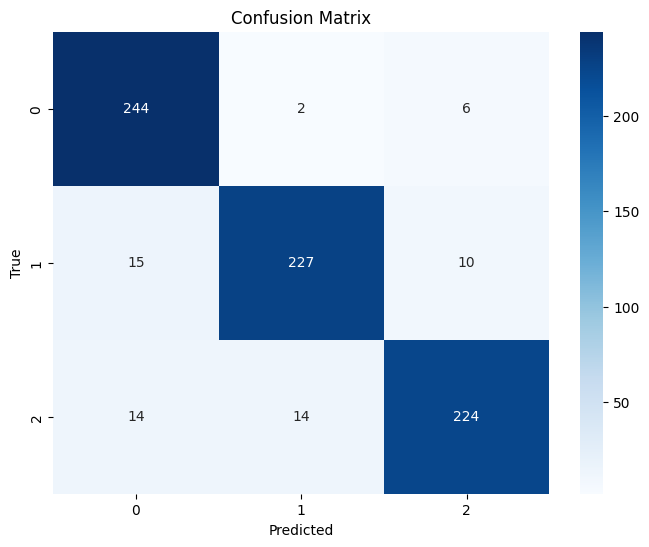

In [ ]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(all_targets, all_preds, target_names=['Environmental', 'Social', 'Governance']))

               precision    recall  f1-score   support

Environmental       0.89      0.97      0.93       252
       Social       0.93      0.90      0.92       252
   Governance       0.93      0.89      0.91       252

     accuracy                           0.92       756
    macro avg       0.92      0.92      0.92       756
 weighted avg       0.92      0.92      0.92       756



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/type_esg_model_weights.pt")